# Hasse Search Space Estimation

## Load Data

In [ ]:
import json
import numpy as np
from os import listdir
from pprint import pprint
from typing import List, Dict

In [ ]:
%pip install matplotlib
import matplotlib.pyplot as plt

  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
     |████████████████████████████████| 113 kB 6.6 MB/s eta 0:00:01
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_11_0_arm64.whl (4.7 MB)
     |████████████████████████████████| 2.8 MB 11.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/christophstein/Documents/jku/hasse_search_spaces/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Load data

def get_file_paths(dir_path: str = "results") -> List[str]:
    file_names = listdir(dir_path)
    file_names = [file_name for file_name in file_names if file_name.endswith(".json")]

    file_paths = [
        f"{dir_path}/{file_name}"  for file_name in file_names
    ]
    return file_paths


def load_data(file_path: str) -> Dict:
    with open(file_path, "r") as data_file:
        return json.load(data_file)

experiment_paths = get_file_paths()
experiments = [
    load_data(file_path) for file_path in experiment_paths
]

# TODO: Remove
experiments = [
    experiment for experiment in experiments if experiment["config"]["gate_count"] <= 10
]

print(f"Experiment count: {len(experiments)}")
print(experiments[0])

Experiment count: 8
{'meta': {'start': '2025-11-14 14:29:53.932920', 'end': '2025-11-14 14:47:01.523753'}, 'config': {'gate_set': '[H, S, T, CX]', 'gate_count': 10, 'qubit_num': 3, 'sample_num': 100000, 'seed_num': 30}, 'results': {'simulation_times': [7.47153, 7.689302, 7.504083, 7.555472, 7.499643, 7.53596, 7.521314, 7.594106, 7.462234, 7.51527, 7.454071, 7.453916, 7.533094, 7.495804, 7.444111, 7.493087, 7.452408, 7.511089, 7.512671, 7.57489, 7.530768, 7.485159, 7.476999, 7.506042, 7.460574, 7.513438, 7.47497, 7.520497, 7.435024, 7.467667], 'mean_simulation_time': 7.504839766666667, 'hasse_duplicate_counts': [136, 144, 136, 152, 164, 159, 154, 142, 165, 157, 132, 141, 130, 137, 144, 139, 158, 133, 147, 141, 152, 146, 185, 152, 140, 142, 143, 164, 147, 149], 'mean_hasse_duplicate_count': 147.7, 'hasse_encoding_times': [24.409497, 24.561948, 24.488765, 24.511919, 24.443124, 24.490618, 24.39568, 24.480262, 24.403193, 24.364116, 24.388311, 24.347988, 24.39826, 24.410229, 24.466509, 24.32

In [62]:
# Filter experiments

def filter_experiments(experiments: List[Dict], target_qubit_nums: List[int] = None, target_gate_counts: List[int] = None, sort_by: str = "qubit_num") -> List:
    assert target_qubit_nums is not None or target_gate_counts is not None

    filtered_experiments = []
    for experiment in experiments:

        if target_qubit_nums is None and experiment["config"]["gate_count"] in target_gate_counts:
            filtered_experiments.append(experiment)
        elif target_gate_counts is None and experiment["config"]["qubit_num"] in target_qubit_nums:
            filtered_experiments.append(experiment)
        elif experiment["config"]["gate_count"] in target_gate_counts and experiment["config"]["qubit_num"] in target_qubit_nums: 
            filtered_experiments.append(experiment)

    filtered_experiments.sort(key=lambda item: item["config"][sort_by])
    return filtered_experiments

## Compute Search Space Size

In [13]:
def calculate_list_search_space_size(qubit_num: int, gate_count: int) -> int:
    # assuming Clifford+T gate set 

    return (qubit_num * (qubit_num - 1) + 3 * qubit_num) ** gate_count

In [96]:
# Calculate search space size

def calculate_expected_duplicates(size: int, sample_num: int) -> int:
    expected_duplicates = sample_num - size + size * (1 - 1/size) ** sample_num
    return expected_duplicates

def estimate_search_space_size(sample_num: int, actual_duplicates: int, lower_bound: int, upper_bound: int) -> int:
    # Expected number of duplicates decreases monotonically as search space increases

    search_range = (lower_bound, upper_bound)
    search_post_count = 3

    while True:

        # cut search interval into bins and evaluate
        search_posts = [
            i * (search_range[1] - search_range[0]) / (search_post_count - 1) + search_range[0] for i in range(search_post_count)
        ]
        search_posts = [int(search_post) for search_post in search_posts]

        smallest_delta = np.inf
        best_i = -1

        for search_post_i, search_post in enumerate(search_posts):
            estimated_duplicates = calculate_expected_duplicates(
                search_post, sample_num)
            delta = abs(estimated_duplicates - actual_duplicates)

            if delta < smallest_delta:
                smallest_delta = delta
                best_i = search_post_i

        if smallest_delta <= 1:
            return search_posts[best_i]

        try:
            if calculate_expected_duplicates(search_posts[best_i], sample_num) > actual_duplicates:
                search_range = (search_posts[best_i], search_posts[best_i + 1])
            else:
                search_range = (search_posts[best_i - 1], search_posts[best_i])
        except IndexError:
            print("Returning because of index error")
            return search_posts[best_i]

    return search_posts[best_i]


{'gate_set': '[H, S, T, CX]', 'gate_count': 5, 'qubit_num': 3, 'sample_num': 100000, 'seed_num': 30}
[9588, 9482, 9606, 9460, 9485, 9476, 9329, 9442, 9524, 9431, 9240, 9299, 9370, 9412, 9393, 9555, 9510, 9314, 9283, 9297, 9402, 9469, 9466, 9425, 9532, 9293, 9426, 9366, 9308, 9501]
Estimates: [487587, 493380, 486660, 494655, 493264, 493728, 502071, 495698, 491063, 496277, 507284, 503809, 499753, 497320, 498479, 489441, 491874, 502998, 504736, 503925, 497899, 494191, 494307, 496625, 490599, 504157, 496509, 499985, 503346, 492337]
Mean estimate: 496741
Actual: 759375

{'gate_set': '[H, S, T, CX]', 'gate_count': 5, 'qubit_num': 4, 'sample_num': 100000, 'seed_num': 30}
[1869, 1896, 1884, 1791, 1876, 1805, 1795, 1835, 1842, 1896, 1884, 1869, 1866, 1855, 1982, 1900, 1871, 1942, 1864, 1856, 1863, 1862, 1883, 1838, 1881, 1833, 1851, 1927, 1871, 1878]
Estimates: [2641410, 2604960, 2619540, 2758050, 2631690, 2736180, 2750760, 2692440, 2680290, 2604960, 2619540, 2641410, 2646270, 2663280, 2488320

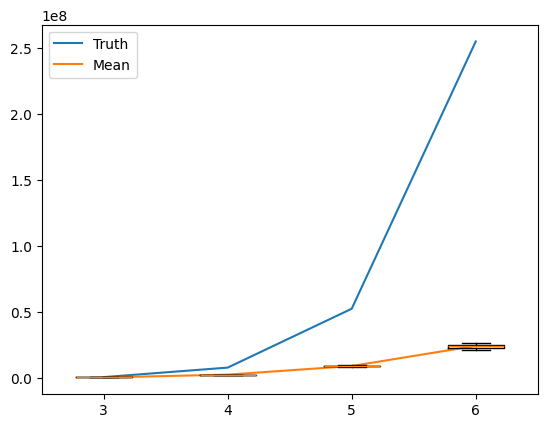

In [97]:
filtered_experiments = filter_experiments(experiments, target_gate_counts=[5])

qubit_nums = []
total_estimates: List[List] = []
total_actual_values: List = []
total_mean_estimates: List = []

for experiment in filtered_experiments:
    print("")
    print(experiment["config"])
    print(experiment["results"]["list_duplicate_counts"])

    qubit_nums.append(experiment["config"]["qubit_num"])

    actual = calculate_list_search_space_size(
        experiment["config"]["qubit_num"], experiment["config"]["gate_count"])
    total_actual_values.append(actual)

    estimates = [
        estimate_search_space_size(
            experiment["config"]["sample_num"], duplicate_count, lower_bound=1, upper_bound=actual * 5)
            for duplicate_count in experiment["results"]["list_duplicate_counts"]
    ]
    
    total_estimates.append(estimates)
    
    mean_estimate = estimate_search_space_size(
            experiment["config"]["sample_num"], experiment["results"]["mean_list_duplicate_count"], lower_bound=1, upper_bound=actual * 5)
    total_mean_estimates.append(mean_estimate)

    print(f"Estimates: {estimates}")
    print(f"Mean estimate: {mean_estimate}")
    print(f"Actual: {actual}")



fig, ax = plt.subplots()
ax.plot(qubit_nums, total_actual_values, label="Truth")
ax.plot(qubit_nums, total_mean_estimates, label="Mean")
ax.boxplot(total_estimates, positions=qubit_nums,
                showfliers=False,
                )

plt.legend()
plt.show()
